# Preprocesado de las noticias

Pre-procesado para eliminar URLS, símbolos. Es decir, cosas que no son palabras

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import style

#One-hot encodding
from sklearn.preprocessing import LabelBinarizer

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
import swifter

#Nicer style
style.use('seaborn') 

In [17]:
import re #regexp

In [18]:
from nltk.tokenize import RegexpTokenizer

Cargamos el dataset de noticias

In [50]:
news = pd.read_csv("../data/Other_datasets/GettingRealAboutFake/all_data_unicode.csv", sep='\t').drop("Unnamed: 0", axis=1)

In [51]:
news.loc[news['type']==0,"type"] = 'fake'
news.loc[news['type']==1,"type"] = 'true'

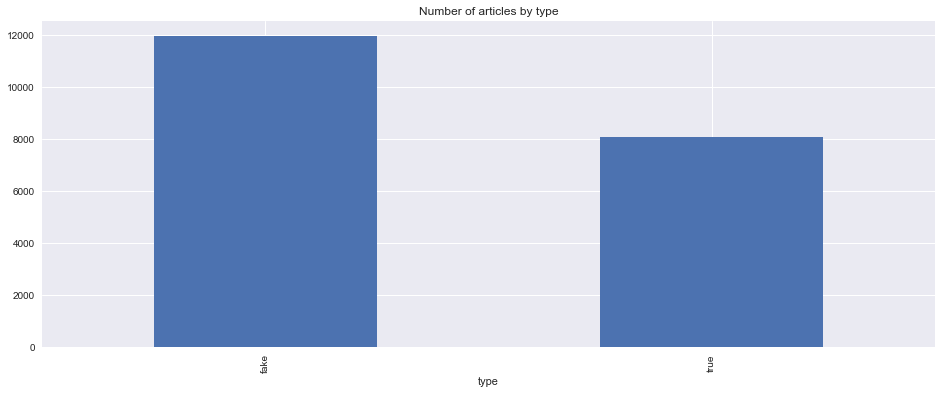

In [52]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['text'].plot.bar(title = "Number of articles by type", ax = ax)

### Limpieza del dataset

In [53]:
def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]    
    return words

Limpiamos los campos que usaremos: Título y contenido

In [54]:
#Clean content
news['text'] = news.swifter.apply(lambda row: clean_text(row['text']), axis=1)
#Clean title
news['title'] = news.swifter.apply(lambda row: clean_text(row['title']), axis=1)

#Select only news with text
news = news[news['title'].str.len() >= 1]
news = news[news['text'].str.len() >= 1]


Pandas Apply: 100%|██████████| 20015/20015 [00:00<00:00, 33809.46it/s]

In [55]:
news.head(3)

,title,text,type
0,"[At, Donald, Trump, Properties, a, Showcase, f...","[They, stood, in, line, at, Trump, Tower, some...",true
1,"[Trump, Foundation, Tells, New, York, It, Has,...","[Donald, J, Trump, foundation, informed, Attor...",true
2,"[Donald, Trump, Prepares, for, White, House, M...","[President, Donald, J, Trump, won, the, White,...",true


### Word2Vec

In [56]:
from gensim.models import KeyedVectors

Cargamos los vectores de un modelo entrenado por Google con los textos de millones de noticias

In [57]:
model = KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin.gz", binary=True,
                                          limit=60000)

Un ejemplo de predicción de palabras similares a "Trump"

In [58]:
model.most_similar("Trump")

[('Donald_Trump', 0.8103920817375183),
 ('Celebrity_Apprentice', 0.51996910572052),
 ('Apprentice', 0.47915542125701904),
 ('Paladino', 0.4655587077140808),
 ('Snooki', 0.4468839764595032),
 ('Harrah', 0.44451743364334106),
 ('MGM_Mirage', 0.44225355982780457),
 ('Vince_McMahon', 0.44097137451171875),
 ('Limbaugh', 0.4399239420890808),
 ('Palin', 0.43837088346481323)]

A continuación convertimos las palabras del título y contenido de las noticias a los índices del vocabulario de Word2Vec.

In [59]:
news['title'] = news.progress_apply(lambda r: 
                        [model.vocab[x].index for x in r['title'] if x in model.vocab], axis=1)


Pandas Apply: 100%|██████████| 19805/19805 [00:00<00:00, 37220.10it/s]

In [60]:
news['text'] = news.progress_apply(lambda r: 
                        [model.vocab[x].index for x in r['text'] if x in model.vocab], axis=1)


Pandas Apply: 100%|██████████| 19805/19805 [00:04<00:00, 4029.66it/s]

Eliminar los artículos que no tengan título (Word2Vec no tenía las palabras originales)

In [61]:
news = news[news['title'].map(len) >= 1]

In [62]:
#Reset index
news = news.reset_index().drop("index", axis=1)

Pero hay un **problema**: La entrada de la red no puede ser variable. Para solucionar esto, es necesario añadir padding a todos los arrays, de tal manera que todos tengan una longitud física.

Si miden menos de una cierta longitud $n$ ($l < n$) entonces se le añadirán "elementos" con ceros hasta alcanzar las dimensiones necesarias. Si mide más, se truncará de tal manera que $l = n$

In [63]:
def pad_array(array, token_len):
    diff_token = token_len - len(array)
    if(diff_token < 0):
        array = array[:token_len] #Truncate
    else:
        #Pad
        array += [0]*diff_token #Pad
        
    return array  

Es necesario encontrar un `token_len` que sea suficiente para que cubra, en general, la longitud de todos los artículos.


Pandas Apply: 100%|██████████| 19155/19155 [00:00<00:00, 47661.92it/s]

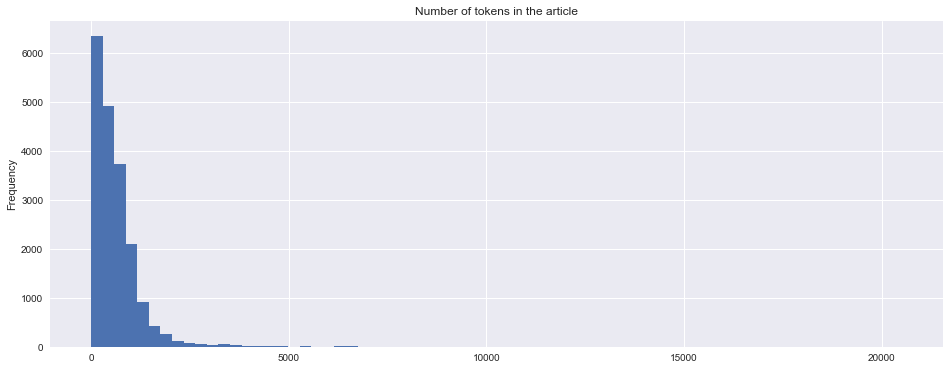

In [64]:
# Longitud en tokens de cada noticia
tokens_numbers = news.swifter.apply(lambda row: len(row['text']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 70, ax=ax)

In [65]:
print("Número medio de tokens por artículo: {}".format(int(np.mean(tokens_numbers))))
print("Desviación estándar de tokens por artículo: {}".format(int(np.std(tokens_numbers))))
print("Mediana de tokens por artículo: {}".format(int(np.median(tokens_numbers))))

Número medio de tokens por artículo: 621
Desviación estándar de tokens por artículo: 717
Mediana de tokens por artículo: 471


In [66]:
max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Ventana de tokens escogida: {} - Cubre el {}% del dataset".format(max_tokens, percent_tokens*100))

Ventana de tokens escogida: 2056 - Cubre el 97.44714173844949% del dataset


In [67]:
n_tokens = 8045

In [68]:
news['text'] = news.apply(lambda r: pad_array(r['text'], n_tokens) , axis=1) #n_tokens

Número medio de tokens por título: 8
Desviación estándar de tokens por título: 3
Mediana de tokens por título: 8
Ventana de tokens escogida: 15 - Cubre el 96.48655703471678% del dataset


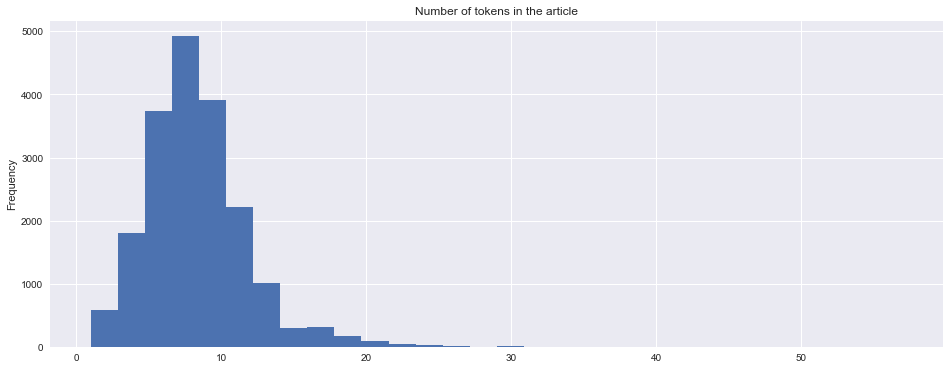

In [69]:
# Longitud en tokens de cada noticia
tokens_numbers = news.apply(lambda row: len(row['title']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 30, ax=ax)

print("Número medio de tokens por título: {}".format(int(np.mean(tokens_numbers))))
print("Desviación estándar de tokens por título: {}".format(int(np.std(tokens_numbers))))
print("Mediana de tokens por título: {}".format(int(np.median(tokens_numbers))))

max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

n_tokens = 93

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Ventana de tokens escogida: {} - Cubre el {}% del dataset".format(max_tokens, percent_tokens*100))

In [70]:
news['title'] = news.progress_apply(lambda r: pad_array(r['title'], n_tokens) , axis=1)


Pandas Apply: 100%|██████████| 19155/19155 [00:00<00:00, 40633.95it/s]